In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

from collections import defaultdict
from typing import Dict, List

# from importlib import reload
# reload(plt)
# plt.xlabel("Hello World")

plt.rcParams['figure.figsize'] = [14, 8]

In [24]:
PLOT_COLORS = ['b', 'g', 'orange']

class SlurmData:
    def __init__(self):
        self.point_counts = []
        self.pi_vals: Dict[int, List[float]] = defaultdict(lambda: [])
        self.times: Dict[int, List[float]] = defaultdict(lambda: [])
            
class DataAnaylzer:
    def __init__(self, slurm_data: List[SlurmData]):
        self.slurm_data = slurm_data
        
    def apply_on_times(self, reduce_function) -> SlurmData:
        res = SlurmData()
        for point_count in self.slurm_data[0].point_counts:
            res.point_counts.append(point_count)
            for i in range(0, 12):
                proc_times = np.empty(len(self.slurm_data))
                for j, data in enumerate(self.slurm_data):
                    proc_times[j] = data.times[point_count][i]
                res.times[point_count].append(reduce_function(proc_times))
        return res
    
    def analyze_times_for_proc(self, p_idx: int, proc: int):
        point_count = self.slurm_data[0].point_counts[p_idx]
        res = []
        for data in self.slurm_data:
            res.append(data.times[point_count][proc])
        return res
    
def to_exp_string(number: float):
    pwr = 0
    while number >= 10:
        number /= 10
        pwr += 1
    number = round(number, 2)
    return '$' + str(number) + "*10^{" + str(pwr) + "}$"

def single_legend(number: float):
    return to_exp_string(number) + " points"

def parse_single_slurm_file(filename: str):
    data = SlurmData()
    with open(filename, 'r') as handle:
        point_count = 0
        for line in handle.readlines():
            if line.startswith("Point count:"):
                point_count = int(line.split(':')[1])
                if point_count not in data.point_counts:
                    data.point_counts.append(point_count)
    
            elif line.startswith("Total time:"): 
                time = float(line.split(':')[1])
                data.times[point_count].append(time)
            elif line.startswith("PI value:"): 
                pi = float(line.split(':')[1])
                data.pi_vals[point_count].append(pi)
    return data

def read_slurm_files():
    total_data = []
    for filename in os.listdir("."):
        if filename.startswith("slurm"):
            total_data.append(parse_single_slurm_file(filename))
    return total_data

def plot_time(time_mean: SlurmData, time_std: SlurmData, num: int):
    point_count = time_mean.point_counts[num]
    plt.errorbar(range(1,13), time_mean.times[point_count], marker = 'o', color=PLOT_COLORS[num],
                 yerr=time_std.times[point_count], linestyle='--', ecolor='red', label=single_legend(point_count))
    plt.xlim(0)
    plt.ylabel("Time [s]")
    plt.xlabel("Processors")
    plt.legend()
    plt.savefig(f"time_{num}.png")
    plt.show()
    
def plot_speedup(time_mean: SlurmData):
    plt.plot(range(1,13), range(1,13), color = 'r', label='y=x')
    speedup_mapping = {}
    for i, point_count in enumerate(time_mean.point_counts):
        speedup = time_mean.times[point_count][0] / np.array(time_mean.times[point_count])
        speedup_mapping[point_count] = speedup
        data_to_plot = speedup
        plt.plot(range(1,13), data_to_plot, marker = 'o', color=PLOT_COLORS[i],
                 linestyle='--', label=single_legend(point_count))
    plt.ylim(0)
    plt.ylabel("Speedup")
    plt.xlabel("Processors")
    plt.legend()
    plt.savefig("speedup.png")
    plt.show()
    return speedup_mapping
    
def plot_efficiency(time_mean: SlurmData):
    plt.plot(range(1,13), [1]*12, color = 'r')
    plt.plot(range(1,13), [0.8]*12, color = 'm', linestyle=':')
    proc_count = range(1,13)
    
    for i, point_count in enumerate(time_mean.point_counts):
        data_to_plot = time_mean.times[point_count][0] / (proc_count * np.array(time_mean.times[point_count]))
        plt.plot(range(1,13), data_to_plot, marker = 'o', color=PLOT_COLORS[i],
                 linestyle='--', label=single_legend(point_count))
    plt.ylim(0)
    plt.ylabel("Efficiency")
    plt.xlabel("Processors")
    plt.legend()
    plt.savefig("efficiency.png")
    plt.show()
    
def plot_serial_fraction(speedup: Dict[int, np.array]): 
    proc_count = np.array(range(2, 13))
    for i, point_count in enumerate(time_mean.point_counts):
        data_to_plot = (1 / speedup[point_count][1:]  -  1 / proc_count) / (1 - 1 / proc_count)
        plt.plot(range(2,13), data_to_plot, marker = 'o', color=PLOT_COLORS[i],
                 linestyle='--', label=single_legend(point_count))
    plt.ylim(0,1)
    plt.xlim(0)
    plt.ylabel("Serial fraction")
    plt.xlabel("Processors")
    plt.legend()
    plt.savefig("sf.png")
    plt.show()

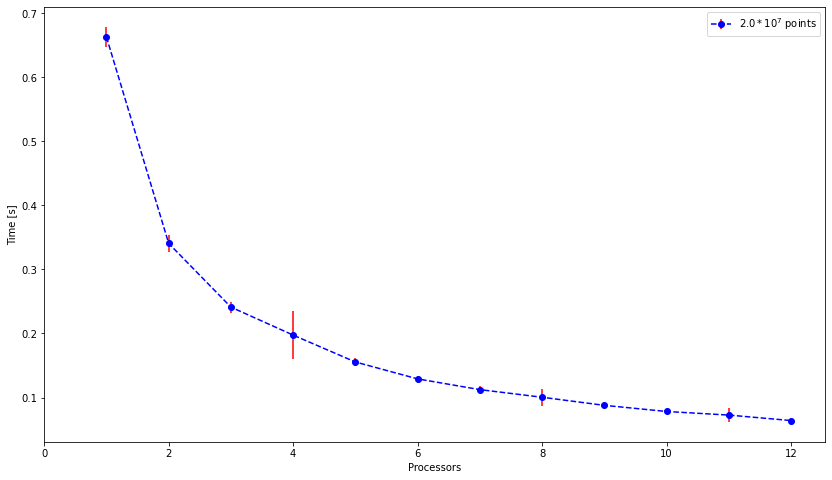

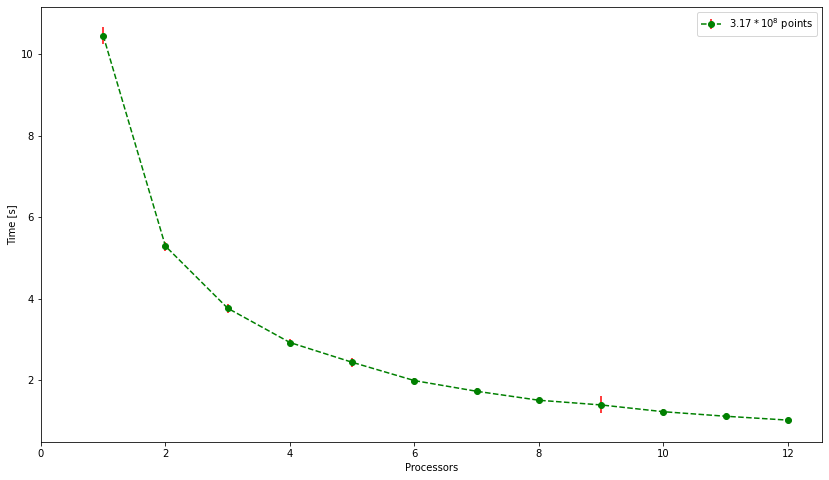

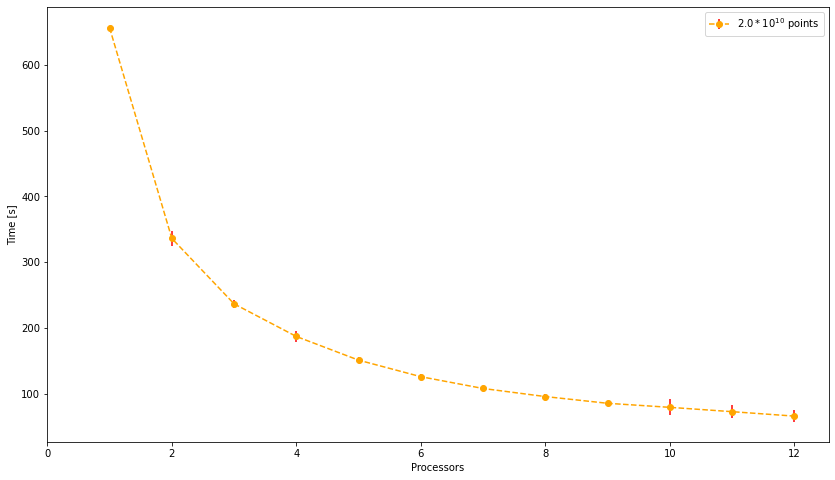

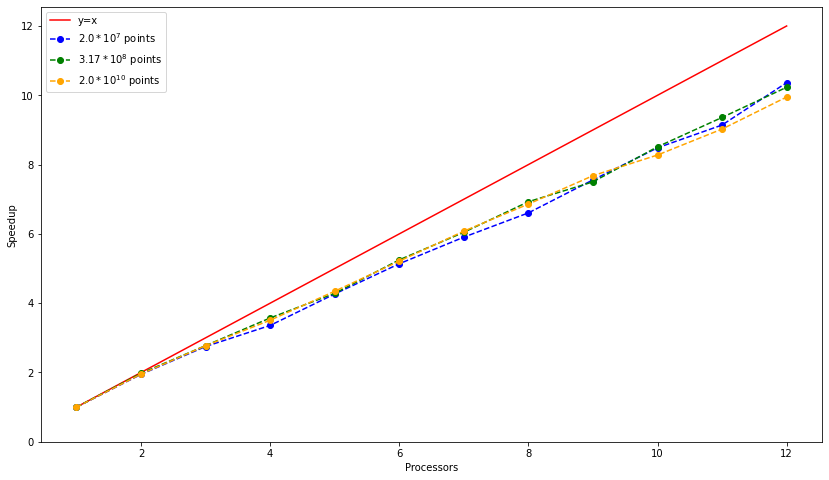

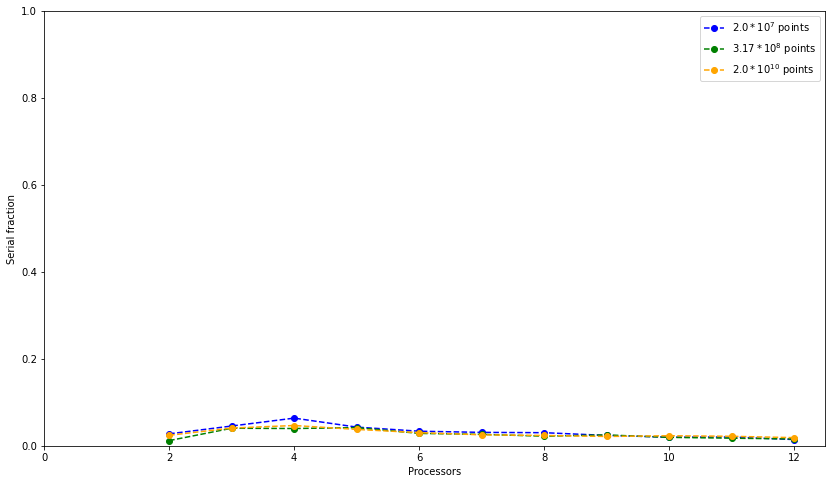

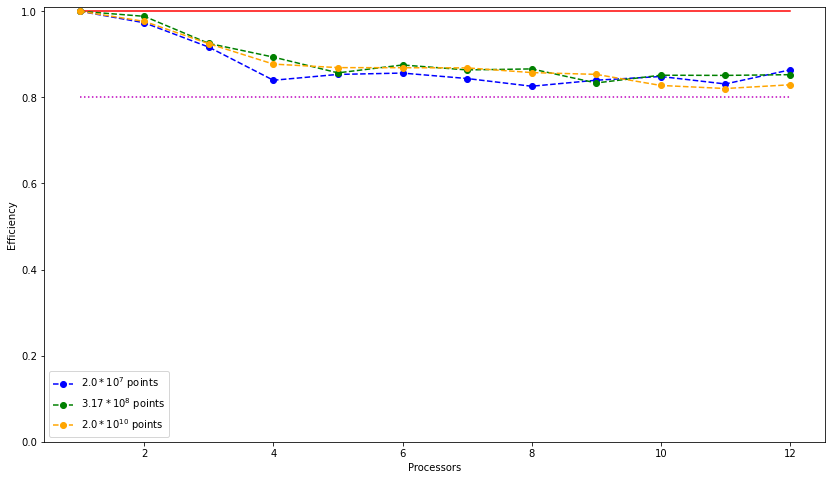

In [25]:
analyzer = DataAnaylzer(read_slurm_files())
time_mean = analyzer.apply_on_times(np.mean)
time_std = analyzer.apply_on_times(np.std)

plot_time(time_mean, time_std, 0)
plot_time(time_mean, time_std, 1)
plot_time(time_mean, time_std, 2)
plot_serial_fraction(plot_speedup(time_mean))
plot_efficiency(time_mean)

In [40]:
for x, y, z in zip(analyzer.analyze_times_for_proc(2, 11),
                   analyzer.analyze_times_for_proc(2, 10),
                   analyzer.analyze_times_for_proc(2, 9)):
    print(x, y, z)


68.801833 67.906878 82.544065
62.248616 67.902554 74.698006
62.196167 74.995063 74.60009
62.284761 67.885113 74.675059
62.339482 75.061164 74.686441
62.311837 75.061641 82.622992
68.851737 67.878705 82.548365
62.242068 67.829004 74.611384
62.210435 67.84256 74.65964
107.711866 75.038128 74.599061
62.228557 75.013989 82.545664
62.294842 67.883831 74.684252
68.849858 117.506913 74.685783
62.30892 75.048639 82.606797
62.267832 75.054522 74.678899
62.364052 75.046607 74.652735
68.880846 67.869502 135.654192
68.791133 67.824831 82.536047
63.477691 67.849125 74.684621
62.264058 67.901484 74.695442
62.248273 67.900962 74.669468
68.78276 67.883254 74.646568
68.822542 75.056624 74.674037
62.309051 75.047671 74.648615
62.245101 67.897236 82.496674
